In [32]:
import legwork.source as source
import legwork.visualisation as vis

import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord


# Demo - Basic SNR Calculation

This demo shows how you can use LEGWORK to compute the SNR of a single binary system, as well as a collection of systems.

In [41]:
import legwork as lw
import astropy.units as u


## Single source SNR calculation

The most basic use case of LEGWORK is to calculate the signal-to-noise ratio for a single stellar-mass binary system. Let’s create a toy source and calculate its SNR (for a 4-year LISA mission by default).

In [42]:
source = lw.source.Source(m_1=10 * u.Msun,
                          m_2=10 * u.Msun,
                          ecc=0.2,
                          f_orb=1e-4 * u.Hz,
                          dist=8 * u.kpc,
                          interpolate_g=False)
source.get_snr().round(2)

array([4.49])

That’s it! Behind the scenes LEGWORK has checked whether the source is eccentric/circular and evolving/stationary and picked the fastest possible way to calculate the SNR accurately.



## Population of sources SNR calculation

If we want to know the SNR of three (or any number of) sources then you can instead provide arrays for each of the arguments and execute the code in exactly the same way.

In [43]:
# supply arrays that are identical to earlier example but different primary masses
sources = lw.source.Source(m_1=[5, 10, 20] * u.Msun,
                           m_2=[10, 10, 10] * u.Msun,
                           ecc=[0.2, 0.2, 0.2],
                           f_orb=[1e-4, 1e-4, 1e-4] * u.Hz,
                           dist=[8, 8, 8] * u.kpc,
                           interpolate_g=False)

sources.get_snr().round(2)

array([2.47, 4.49, 7.85])

--------------------------------------------------

Next let’s create a random collection of possible LISA sources in order to assess their detectability.



In [6]:
# create a random collection of sources
n_values = 1500
m_1 = np.random.uniform(0, 10, n_values) * u.Msun
m_2 = np.random.uniform(0, 10, n_values) * u.Msun
dist = np.random.normal(8, 1.5, n_values) * u.kpc
f_orb = 10**(-5 * np.random.power(3, n_values)) * u.Hz
ecc = 1 - np.random.power(5, n_values)

We can instantiate a Source class using these random sources in order to analyse the population. This Source class has many methods for calculating strains, visualising populations and more.

In [14]:
sources = source.Source(m_1=m_1, m_2=m_2, ecc=ecc, dist=dist, f_orb=f_orb)

Therefore, let’s calculate the SNR for these sources. We set verbose=True to give an impression of what sort of sources we have created. This function will split the sources based on whether they are stationary/evolving and circular/eccentric and use one of 4 SNR functions for each subpopulation.

In [9]:
snr = sources.get_snr(verbose=True)

Calculating SNR for 1500 sources
	0 sources have already merged
	1389 sources are stationary
		402 sources are stationary and circular
		987 sources are stationary and eccentric
	111 sources are evolving
		26 sources are evolving and circular
		85 sources are evolving and eccentric


These SNR values are now stored in sources.snr and we can mask those that don’t meet some detectable threshold.

In [10]:
detectable_threshold = 7
detectable_sources = sources.snr > 7
print("{} of the {} sources are detectable".format(len(sources.snr[detectable_sources]), n_values))

592 of the 1500 sources are detectable


And just like that we know the number of detectable sources! It could be interesting to see how the SNR varies with orbital frequency so let’s use the legwork.source.Source.plot_source_variables() to create a 2D density distribution of these variables.

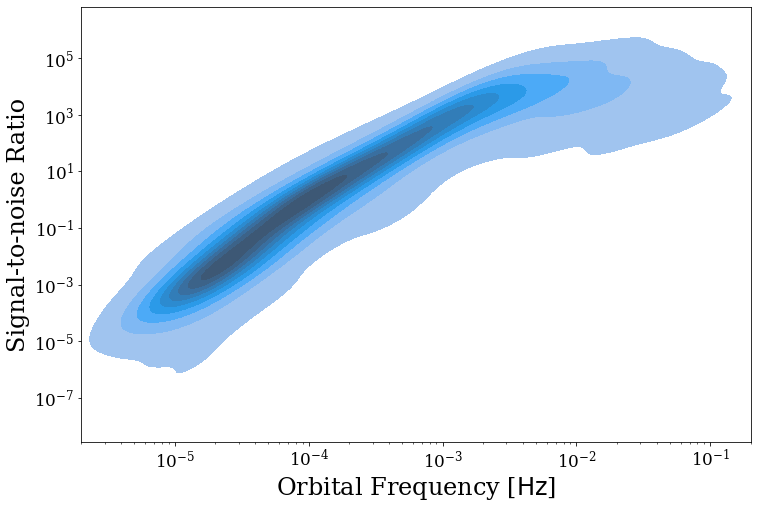

In [11]:
fig, ax = sources.plot_source_variables(xstr="f_orb", ystr="snr", disttype="kde", log_scale=(True, True),
                                        fill=True, xlim=(2e-6, 2e-1), which_sources=sources.snr > 0)

The reason for this shape may not be immediately obvious. However, if we also use the visualisation module to overlay the LISA sensitivity curve, it becomes clear that the SNRs increase in step with the decrease in the noise and flatten out as the sensitivity curve does as we would expect.

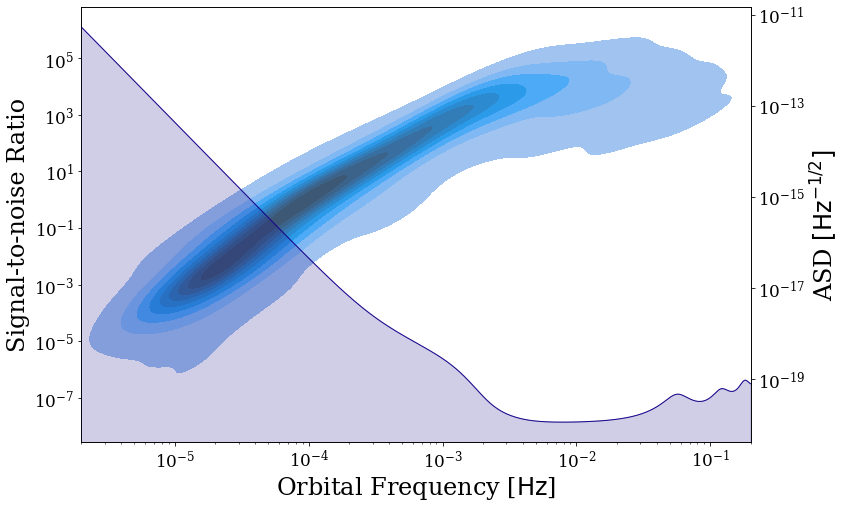

In [12]:
# create the same plot but set `show=False`
fig, ax = sources.plot_source_variables(xstr="f_orb", ystr="snr", disttype="kde", log_scale=(True, True),
                                        fill=True, show=False, which_sources=sources.snr > 0)

# duplicate the x axis and plot the LISA sensitivity curve
right_ax = ax.twinx()
frequency_range = np.logspace(np.log10(2e-6), np.log10(2e-1), 1000) * u.Hz
vis.plot_sensitivity_curve(frequency_range=frequency_range, fig=fig, ax=right_ax)

plt.show()

# Instantiating a Source Class

Let’s start by creating a random collection of possible LISA sources.



In [20]:
from legwork import source, utils, visualisation


In [21]:
# create a random collection of sources
n_values = 1500
m_1 = np.random.uniform(0, 10, n_values) * u.Msun
m_2 = np.random.uniform(0, 10, n_values) * u.Msun
dist = np.random.normal(8, 1.5, n_values) * u.kpc
f_orb = 10**(-5 * np.random.power(3, n_values)) * u.Hz
ecc = 1 - np.random.power(3, n_values)

We can instantiate a Source class using these random sources as follows:



In [22]:
sources = source.Source(m_1=m_1, m_2=m_2, ecc=ecc, dist=dist, f_orb=f_orb, gw_lum_tol=0.05, stat_tol=1e-2,
                        interpolate_g=True, interpolate_sc=True,
                        sc_params={
                            "instrument": "LISA",
                            "custom_psd": None,
                            "t_obs": 4 * u.yr,
                            "L": 2.5e9 * u.m,
                            "approximate_R": False,
                            "confusion_noise": 'robson19'
                        })

Another thing to consider when creating a new source class is whether to interpolate the  function from Peters (1963). This function is a complex combination of Bessel functions and thus is slow to compute. We therefore add the option to load in pre-computed  values and interpolate them instead of computing the values directly. We perform this interpolation once upon class creation and use it throughout after this. The pre-computed values span 1000 values of eccentricity and 10000 harmonics and thus are accurate for .


We can illustrate the difference in speed and results for the interpolated function vs. the real one.



In [23]:
%%timeit
e_range = np.random.uniform(0.0, 0.995, 1000)
n_range = np.arange(1, 150 + 1).astype(int)

# the argsorts here unsort the output since interp2d automatically sorts it
sources.g(n_range, e_range)[np.argsort(e_range).argsort()]

2.69 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
e_range = np.random.uniform(0.0, 0.995, 1000)
n_range = np.arange(1, 150 + 1).astype(int)

E, N = np.meshgrid(e_range, n_range)

utils.peters_g(N, E)

1.9 s ± 78.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


You can see here that the interpolated function is roughly 500 times faster. Now let’s ensure that they are giving the same results.



In [25]:
e_range = np.random.uniform(0.0, 0.9, 10)
n_range = np.arange(1, 150 + 1).astype(int)

g_interpolated = sources.g(n_range, e_range)[np.argsort(e_range).argsort()]

N, E = np.meshgrid(n_range, e_range)

g_true = utils.peters_g(N, E)

In [26]:
difference = np.abs(g_true - g_interpolated)
print("The largest difference between the interpolated and true value is {:.2e}".format(np.max(difference)))
print("Whilst the average difference is {:.2e}".format(np.mean(difference)))

The largest difference between the interpolated and true value is 4.88e-09
Whilst the average difference is 2.39e-10


So the functions also give pretty much the same values. However, if you happen to have a lot of computing power and time is not a factor for you then setting interpolate_g=False will give you more accurate results.



# Strain and SNR calculations

## Strain functions

The source class provides a convenient wrapper around the functions from the strain module and allows you to compute either the strain or characteristic strain for any number of harmonics and any subset of the sources.

Let’s try this out with the same source class instance from earlier.

In [27]:
# compute h_c_n for every source for the first four harmonics
h_c_n4 = sources.get_h_c_n(harmonics=[1, 2, 3, 4])
print(h_c_n4)

[[1.93015241e-17 1.09296133e-16 8.36216668e-17 4.66517753e-17]
 [3.87793094e-17 1.53849425e-16 1.52150544e-16 1.07895587e-16]
 [4.08541078e-17 1.37576356e-16 1.51279419e-16 1.18003163e-16]
 ...
 [3.83028649e-18 3.32909382e-17 1.78799958e-17 7.08247084e-18]
 [9.59352538e-18 6.74959544e-17 4.34018821e-17 2.04877404e-17]
 [8.30670105e-18 1.55651990e-16 4.09453566e-17 8.00518850e-18]]


## Signal-to-Noise Ratio

The snr module of LEGWORK contains four functions for calculating the SNR depending on whether a binary is stationary/evolving and circular/eccentric using various approximations. However, the source class takes cares of sending the right binaries to the right functions and all you have to do is set the gw_lum_tol and stat_tol when instantiating the class (see above) and then call legwork.source.Source.get_snr().

This splits the sources into (up to) 4 subsets and calculates their SNRs before recollecting them and storing the result in source.snr.

Let’s try this out. Note that we run with verbose=True here so that you can see the size of subpopulation.

In [28]:
snr_4 = sources.get_snr(verbose=True)


Calculating SNR for 1500 sources
	0 sources have already merged
	1380 sources are stationary
		249 sources are stationary and circular
		1131 sources are stationary and eccentric
	120 sources are evolving
		17 sources are evolving and circular
		103 sources are evolving and eccentric


We can also adjust the length of the LISA mission to see how this affects the SNR. It is also important in general to update the sensitivity curve parameters for the interpolation so that the interpolated sensitivity curve matches the updated mission length. LEGWORK handles this for get_snr as long as reinterpolate_sc=True.



In [29]:
snr_10 = sources.get_snr(t_obs=10 * u.yr, verbose=True)

Calculating SNR for 1500 sources
	0 sources have already merged
	1346 sources are stationary
		244 sources are stationary and circular
		1102 sources are stationary and eccentric
	154 sources are evolving
		22 sources are evolving and circular
		132 sources are evolving and eccentric


Note that you can see that the number of stationary binaries has decreased slightly since some binaries may just be on the cusp of no longer being stationary and extending the time means they change frequency enough to be labelled as evolving. It could be interesting to do this to see how the number of detectable binaries changes.



In [30]:
n_detect_4 = len(snr_4[snr_4 > 7])
n_detect_10 = len(snr_10[snr_10 > 7])
print("{} binaries are detectable over 4 years".format(n_detect_4))
print("Whilst extending to a 10 year mission gives {}".format(n_detect_10))

618 binaries are detectable over 4 years
Whilst extending to a 10 year mission gives 648


# Position-inclination-polarisation specfic sources

For some sources, you may already know the positions and this means that you can use a more specific SNR calculation (see the derivations for more details) rather than an average. Note that since this SNR calculation also considers frequency spreading due to doppler modulation from the detector orbit, the SNR will always be lower than in the fully averaged case.

We can input this when instantiating the source. For positions we use the Skycoord Class from Astropy, which allows you to specific the coordinates in any frame and it will automatically convert it to the necessary coordinates in LEGWORK.

In [33]:
sources_specific = source.Source(m_1=m_1, m_2=m_2, f_orb=f_orb, dist=dist, ecc=np.repeat(0.0, len(m_1)),
                                 position=SkyCoord(lon=np.random.uniform(0, 2 * np.pi) * u.rad,
                                                   lat=np.random.uniform(-np.pi / 2, np.pi / 2) * u.rad,
                                                   distance=dist, frame="heliocentrictrueecliptic"),
                                 inclination=np.arcsin(np.random.uniform(-1, 1, len(m_1))) * u.rad,
                                 polarisation=np.random.uniform(0, 2 * np.pi, len(m_1)) * u.rad)
sources_specific.get_snr()

array([5.25667805e-01, 1.14792629e-03, 1.86728990e+01, ...,
       2.39678551e+02, 1.31916888e+02, 5.12837930e+03])

In [35]:
sources_average = source.Source(m_1=m_1, m_2=m_2, f_orb=f_orb, dist=dist, 
                                ecc=np.repeat(0.0, len(m_1)))
sources_average.get_snr()

array([7.23223086e-01, 1.75272729e-03, 3.26500444e+01, ...,
       3.10000804e+02, 2.32145636e+02, 1.13696895e+04])

Let’s plot the ratio of the SNR for the two cases using the visualisation module.



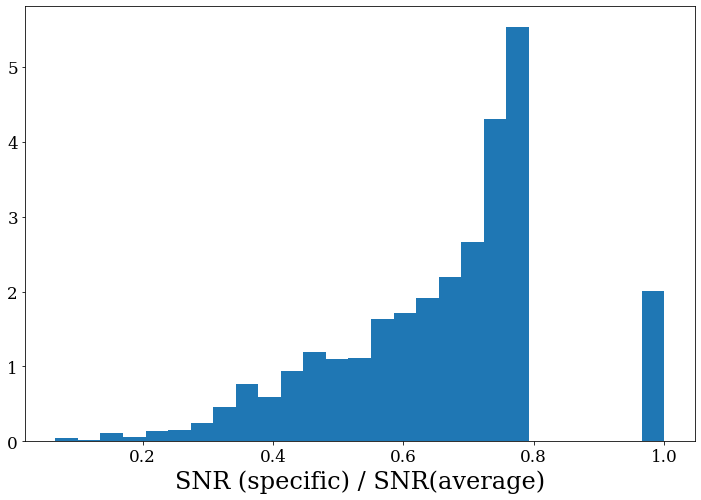

In [36]:
snr_ratio = sources_specific.snr / sources_average.snr
fig, ax = visualisation.plot_1D_dist(snr_ratio, bins="fd", xlabel="SNR (specific) / SNR(average)")

As you can see, the SNR for a specific source is always lower than for the average source. This is because the modulation reduces the strain amplitude as the smearing in frequency reduces the amount of signal build up at the true source frequency.

## Parameters Distributions

The first function is legwork.source.Source.plot_source_variables() which can create either 1D or 2D distributions of any subpopulation of sources.

Let’s take it for a spin with a collection of stationary binaries.



In [37]:
# create a random collection of sources
n_values = 15000
m_1 = np.random.uniform(0, 10, n_values) * u.Msun
m_2 = np.random.uniform(0, 10, n_values) * u.Msun
dist = np.random.normal(8, 1.5, n_values) * u.kpc
f_orb = 10**(np.random.normal(-5, 0.5, n_values)) * u.Hz
ecc = 1 - np.random.power(3, n_values)

sources = source.Source(m_1=m_1, m_2=m_2, ecc=ecc, dist=dist, f_orb=f_orb)

This function will let you plot any of several parameters (listed in the table below) and work out the units for the axes labels automatically based on the values in the source class.


We can start simple and just plot the orbital frequency distribution for all sources.


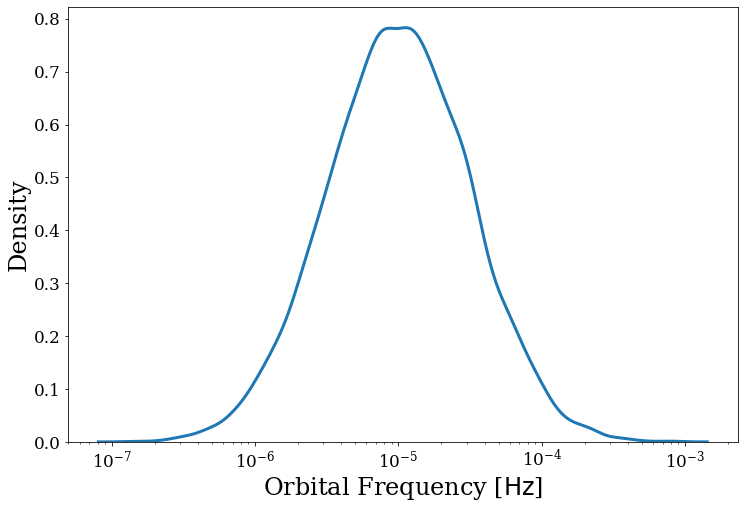

In [38]:
fig, ax = sources.plot_source_variables(xstr="f_orb", disttype="kde", log_scale=True, linewidth=3)

But we could also try to see how the detectable population is different from the entire population. Let’s create two frequency KDEs, one for the detectable binaries and another for all of them. For this we will use the which_sources parameter and pass a mask on the SNR.

Calculating SNR for 15000 sources
	0 sources have already merged
	15000 sources are stationary
		2786 sources are stationary and circular
		12214 sources are stationary and eccentric


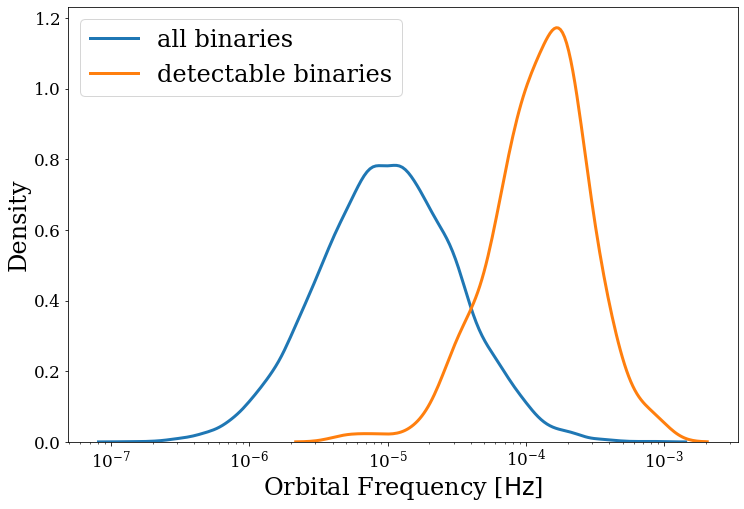

In [40]:
# calculate the SNR
snr = sources.get_snr(verbose=True)

# mask detectable binaries
detectable = snr > 7

# plot all binaries
fig, ax = sources.plot_source_variables(xstr="f_orb", disttype="kde", log_scale=True, linewidth=3,
                                        show=False, label="all binaries")

# plot all binaries
fig, ax = sources.plot_source_variables(xstr="f_orb", disttype="kde", log_scale=True, linewidth=3, fig=fig,
                                        ax=ax, which_sources=detectable, label="detectable binaries",
                                        show=False)

ax.legend()

plt.show()

Here’s we can see that the distribution is shifted to higher frequencies for detectable binaries which makes sense since these are easier to detect.